In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [16]:

data=pd.read_csv("./laboratory.csv")

In [17]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [18]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [19]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [20]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','o3','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
dates_to_remove = ['2023-04-17', '2023-05-21']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen   pm10     co      co2      so2     no2           timestamp  \
0      20.688  0.007  1.522  548.505   38.461  27.406 2023-03-22 17:42:49   
1      20.687  0.001  1.521  543.500   38.462  27.771 2023-03-22 17:44:48   
2      20.687  0.000  1.521  542.134   38.463  27.913 2023-03-22 17:46:50   
3      20.688  0.213  1.521  539.314   38.462  28.165 2023-03-22 17:48:48   
4      20.687  0.152  1.522  543.551   38.462  28.421 2023-03-22 17:50:49   
...       ...    ...    ...      ...      ...     ...                 ...   
51181  20.906  4.770  1.530  517.499  176.872  27.301 2023-06-06 16:52:03   
51182  20.906  4.169  1.529  524.201  177.372  26.331 2023-06-06 16:53:57   
51183  20.907  5.038  1.529  516.942  173.799  24.875 2023-06-06 16:56:11   
51184  20.905  5.092  1.530  517.797  167.632  23.244 2023-06-06 16:58:12   
51185  20.907  4.216  1.532  512.732  162.133  22.675 2023-06-06 17:00:10   

         pm1  dewpt     tvoc   sound  pm2_5  temperature  pressure  humidit

Modifier le nom de timestamp et le convertir en index

In [21]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen   pm10     co      co2     so2     no2  pm1  \
date                                                                      
2023-03-22 17:42:49  20.688  0.007  1.522  548.505  38.461  27.406  0.0   
2023-03-22 17:44:48  20.687  0.001  1.521  543.500  38.462  27.771  0.0   
2023-03-22 17:46:50  20.687  0.000  1.521  542.134  38.463  27.913  0.0   
2023-03-22 17:48:48  20.688  0.213  1.521  539.314  38.462  28.165  0.0   
2023-03-22 17:50:49  20.687  0.152  1.522  543.551  38.462  28.421  0.0   

                     dewpt  tvoc   sound  pm2_5  temperature  pressure  \
date                                                                     
2023-03-22 17:42:49  8.114   0.0  21.999    0.0       20.867   983.066   
2023-03-22 17:44:48  8.095   0.0  24.962    0.0       20.865   983.102   
2023-03-22 17:46:50  8.090   0.0  25.293    0.0       20.866   983.112   
2023-03-22 17:48:48  8.088   0.0  26.403    0.0       20.864   983.112   
2023-03-22 17:50:49  8.091   0

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

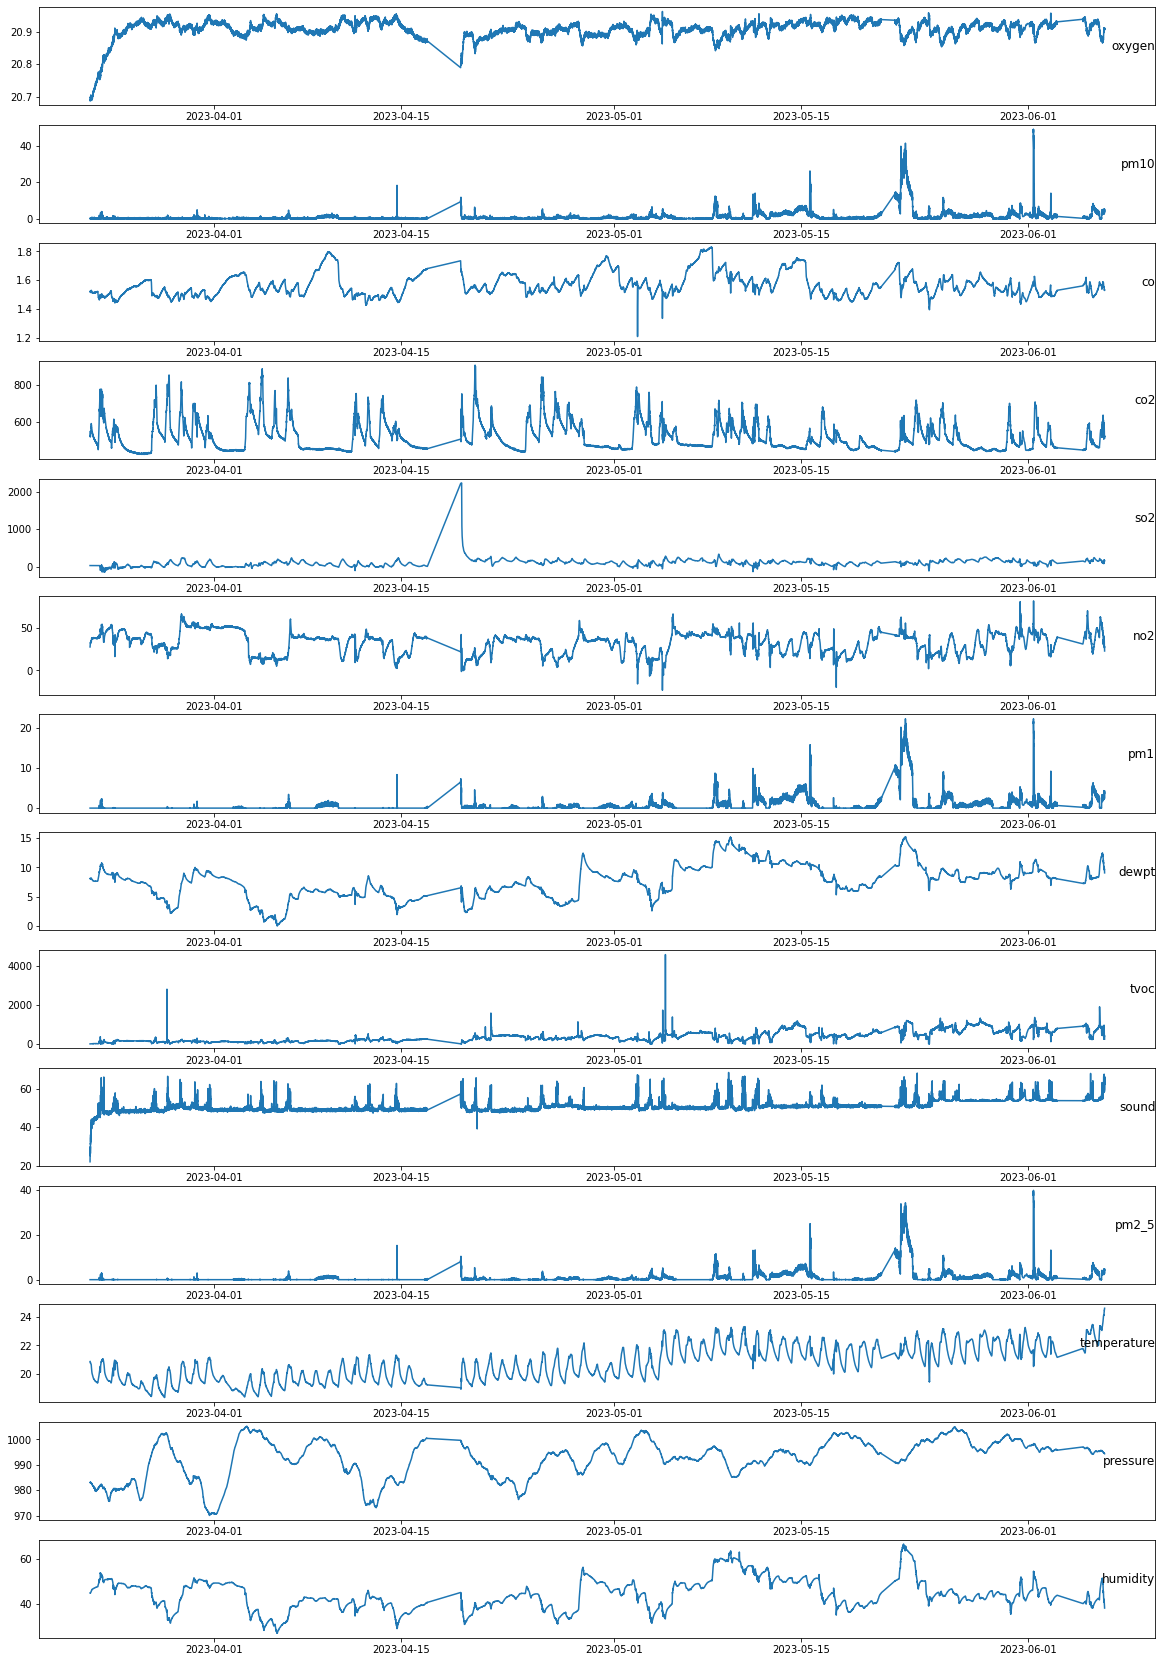

In [22]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [23]:
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,
2023-03-22 17:42:49,20.688,0.007,1.522,548.505,38.461,27.406,0.000,8.114,0.000,21.999,0.000,20.867,983.066,44.833
2023-03-22 17:44:48,20.687,0.001,1.521,543.500,38.462,27.771,0.000,8.095,0.000,24.962,0.000,20.865,983.102,44.784
2023-03-22 17:46:50,20.687,0.000,1.521,542.134,38.463,27.913,0.000,8.090,0.000,25.293,0.000,20.866,983.112,44.768
2023-03-22 17:48:48,20.688,0.213,1.521,539.314,38.462,28.165,0.000,8.088,0.000,26.403,0.000,20.864,983.112,44.766
2023-03-22 17:50:49,20.687,0.152,1.522,543.551,38.462,28.421,0.000,8.091,0.000,25.934,0.000,20.867,983.097,44.768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 16:52:03,20.906,4.770,1.530,517.499,176.872,27.301,3.683,9.514,314.435,66.425,4.150,24.533,994.396,39.472
2023-06-06 16:53:57,20.906,4.169,1.529,524.201,177.372,26.331,3.232,9.412,285.701,65.066,3.800,24.546,994.381,39.171
2023-06-06 16:56:11,20.907,5.038,1.529,516.942,173.799,24.875,4.050,9.232,244.609,62.035,4.670,24.572,994.372,38.641


**Multivariate LSTM Predictive Modeling**

In [24]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [25]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [26]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
1,0.003632,0.000143,0.504839,0.255490,0.075925,0.484318,0.0,0.532229,0.0,0.000000,...,0.000020,0.503226,0.245141,0.075925,0.487801,0.0,0.530976,0.0,0.063808,0.0
2,0.000000,0.000020,0.503226,0.245141,0.075925,0.487801,0.0,0.530976,0.0,0.063808,...,0.000000,0.503226,0.242316,0.075926,0.489156,0.0,0.530646,0.0,0.070936,0.0
3,0.000000,0.000000,0.503226,0.242316,0.075926,0.489156,0.0,0.530646,0.0,0.070936,...,0.004342,0.503226,0.236485,0.075925,0.491561,0.0,0.530514,0.0,0.094840,0.0
4,0.003632,0.004342,0.503226,0.236485,0.075925,0.491561,0.0,0.530514,0.0,0.094840,...,0.003099,0.504839,0.245246,0.075925,0.494003,0.0,0.530712,0.0,0.084740,0.0
5,0.000000,0.003099,0.504839,0.245246,0.075925,0.494003,0.0,0.530712,0.0,0.084740,...,0.002120,0.504839,0.242031,0.075925,0.497037,0.0,0.530382,0.0,0.020824,0.0


In [27]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-11].values, train.iloc[:, -11:].values
test_X, test_y = test.iloc[:, :-11].values, test.iloc[:, -11:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(39992, 1, 14) (39992, 11) (9997, 1, 14) (9997, 11)


Define the RNN model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [28]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units = 11))
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                3250      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 11)                561       
Total params: 3,811
Trainable params: 3,811
Non-trainable params: 0
_________________________________________________________________
None


Training the RNN model

Epoch 1/500
1111/1111 - 1s - loss: 0.0799 - val_loss: 0.0564
Epoch 2/500
1111/1111 - 1s - loss: 0.0327 - val_loss: 0.0446
Epoch 3/500
1111/1111 - 1s - loss: 0.0271 - val_loss: 0.0396
Epoch 4/500
1111/1111 - 1s - loss: 0.0272 - val_loss: 0.0396
Epoch 5/500
1111/1111 - 1s - loss: 0.0274 - val_loss: 0.0420
Epoch 6/500
1111/1111 - 1s - loss: 0.0276 - val_loss: 0.0395
Epoch 7/500
1111/1111 - 1s - loss: 0.0278 - val_loss: 0.0394
Epoch 8/500
1111/1111 - 1s - loss: 0.0277 - val_loss: 0.0411
Epoch 9/500
1111/1111 - 1s - loss: 0.0276 - val_loss: 0.0407
Epoch 10/500
1111/1111 - 1s - loss: 0.0276 - val_loss: 0.0409
Epoch 11/500
1111/1111 - 1s - loss: 0.0275 - val_loss: 0.0421
Epoch 12/500
1111/1111 - 1s - loss: 0.0273 - val_loss: 0.0423
Epoch 13/500
1111/1111 - 1s - loss: 0.0269 - val_loss: 0.0413
Epoch 14/500
1111/1111 - 1s - loss: 0.0269 - val_loss: 0.0412
Epoch 15/500
1111/1111 - 1s - loss: 0.0267 - val_loss: 0.0412
Epoch 16/500
1111/1111 - 1s - loss: 0.0267 - val_loss: 0.0396
Epoch 17/500
1111

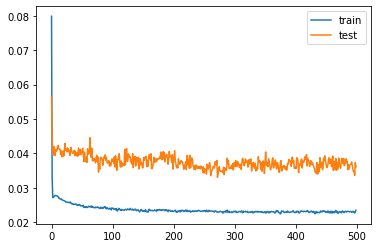

In [29]:
history = model.fit(train_X, train_y, epochs=500, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating RNN models

             0         1         2           3           4          5   \
9992  20.921318  3.419003  1.523052  511.304535  129.142654  31.076723   
9993  20.921738  3.475745  1.520133  511.261902  126.251114  30.686550   
9994  20.921267  3.182410  1.520708  513.335266  129.304749  29.751493   
9995  20.923437  3.816219  1.515384  506.734619  130.904465  28.705175   
9996  20.922789  3.909722  1.514278  510.786499  126.800987  27.571194   

            6         7           8          9         10  
9992  2.527380  9.660412  414.635590  54.066723  3.078722  
9993  2.551776  9.728839  393.234314  55.117245  3.094657  
9994  2.334640  9.629945  392.997345  54.805630  2.829951  
9995  2.807786  9.427121  367.281281  53.938667  3.444983  
9996  2.866487  9.423494  358.527710  54.912331  3.501640  
             0      1      2           3           4          5      6   \
9992  20.906000  4.770  1.530  517.499023  176.871979  27.301004  3.683   
9993  20.906000  4.169  1.529  524.200989  17

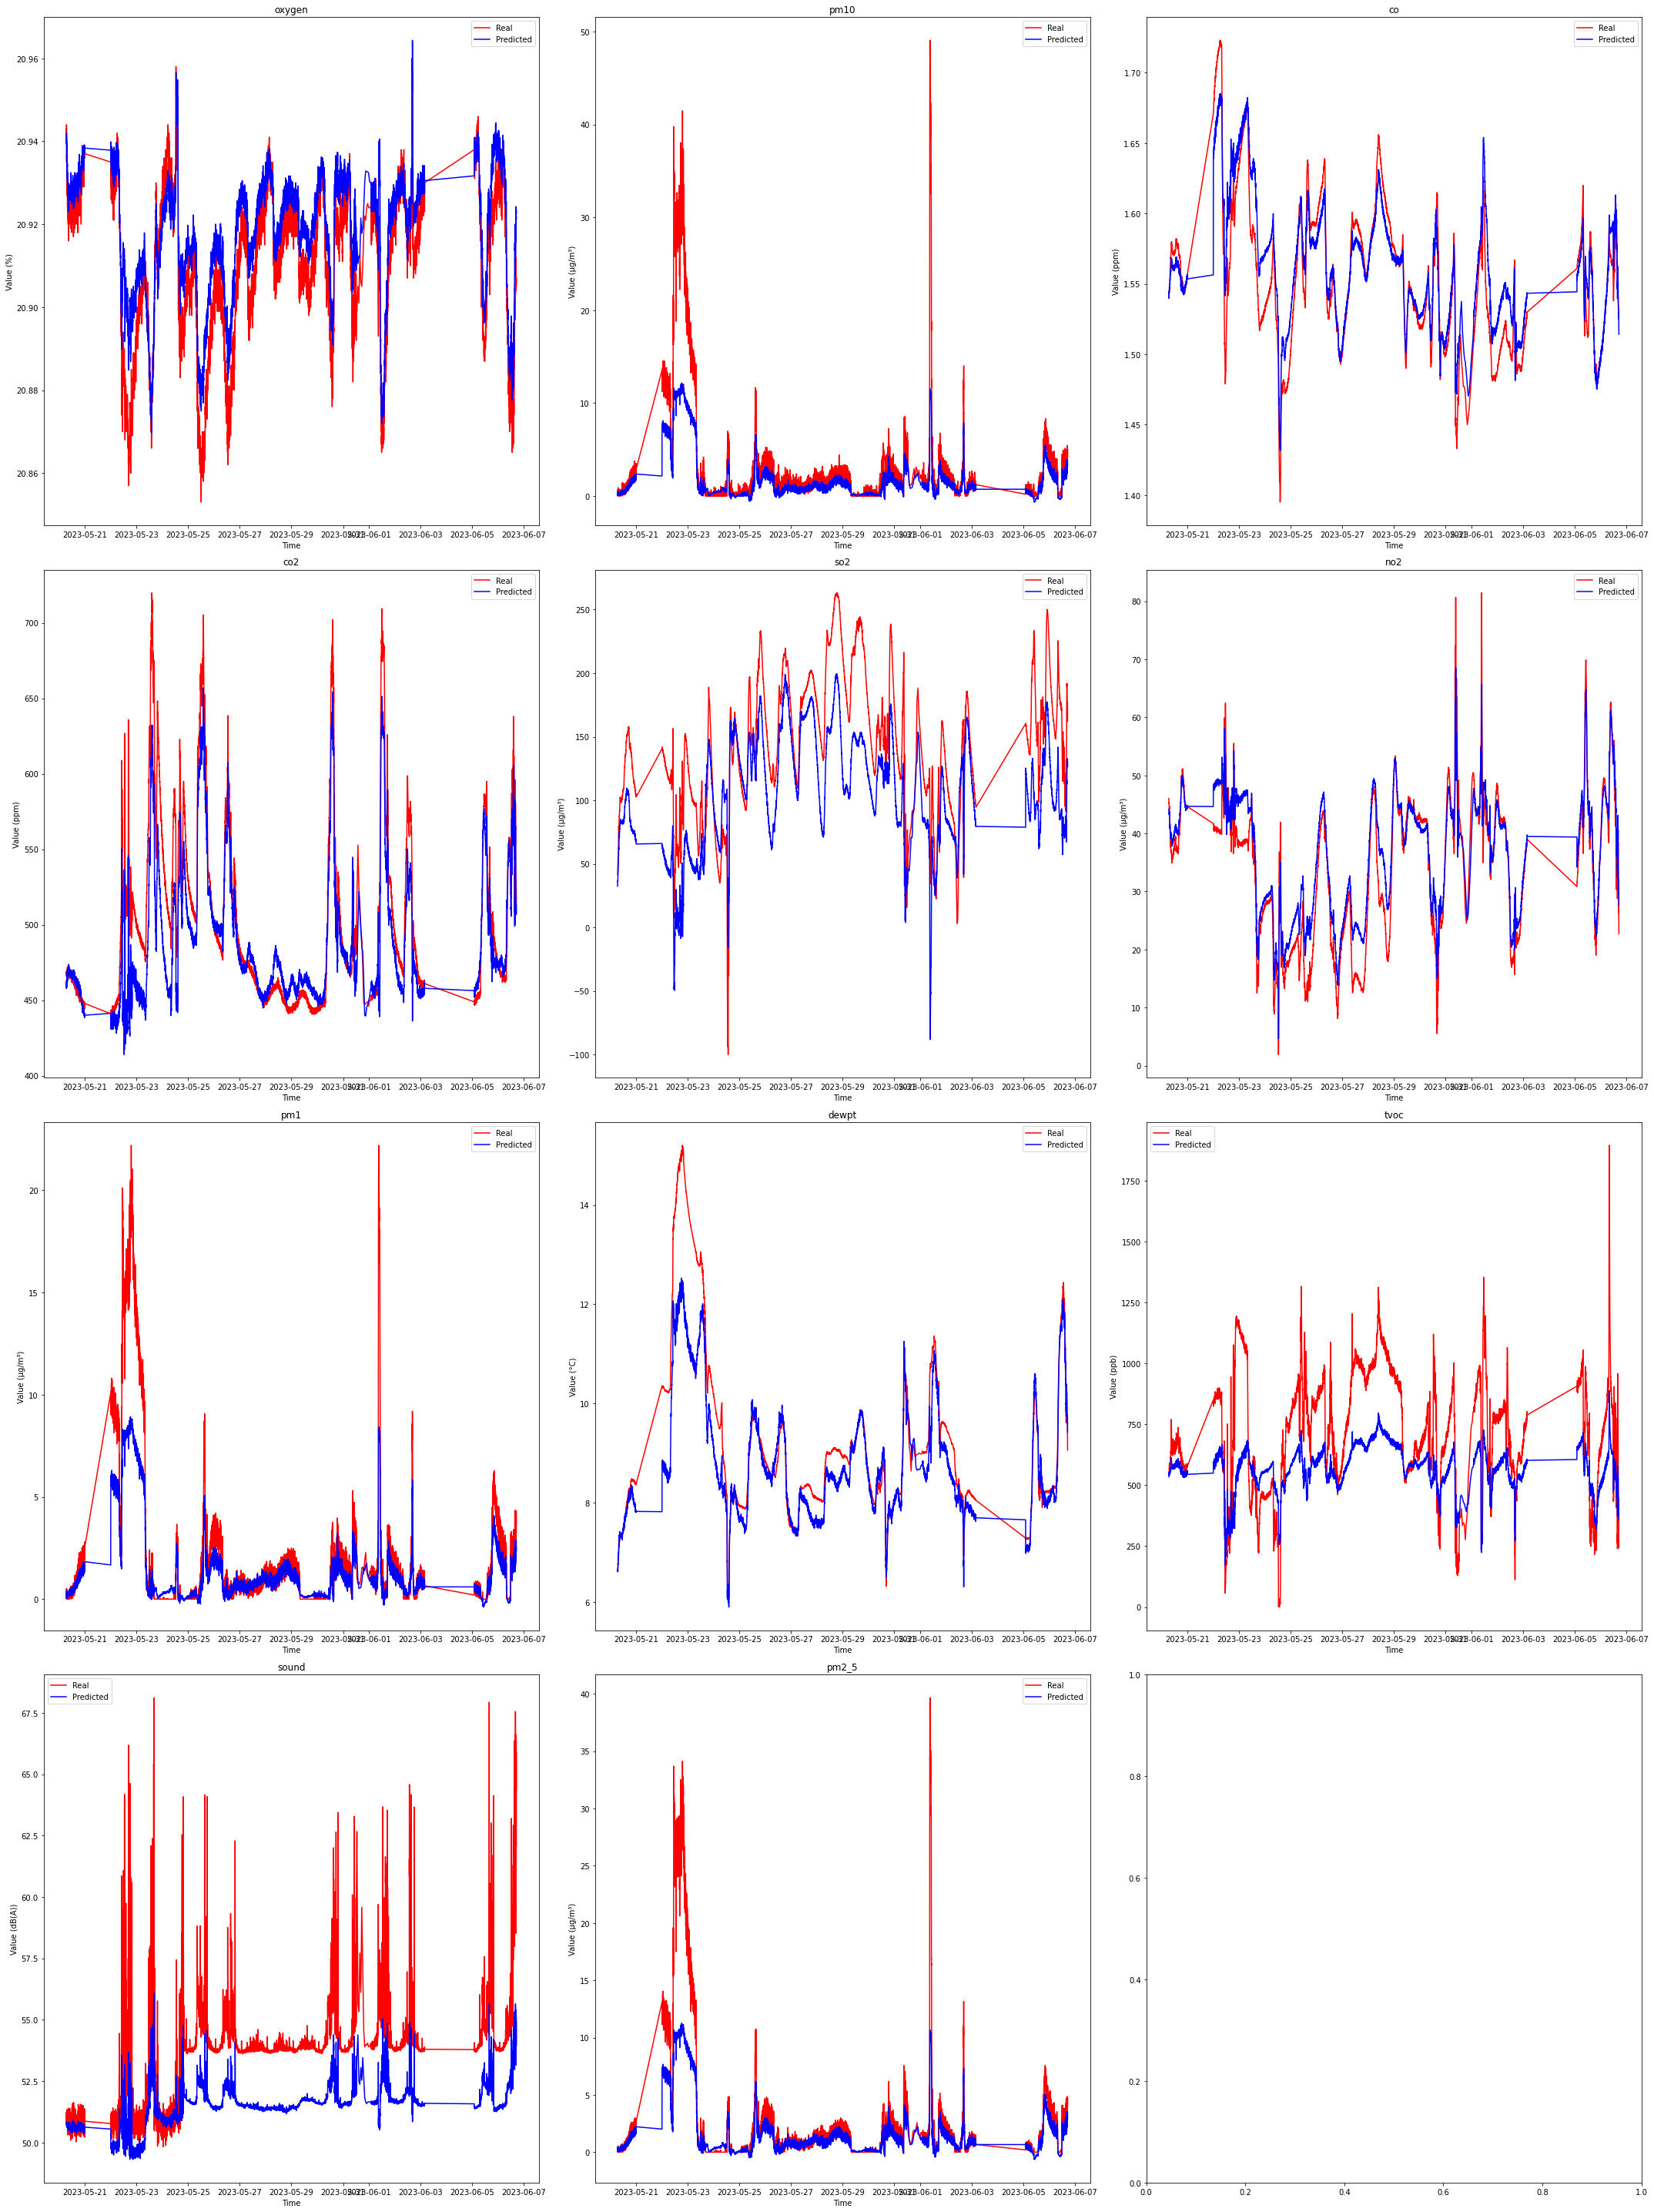

In [30]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [11, 12, 13]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
inv_yhat_df = pd.DataFrame(inv_yhat)
print(inv_yhat_df.tail())

test_y = test_y.reshape((len(test_y), 11))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.tail())

dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'sound': 9,'pm2_5': 10
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [31]:
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [11, 12, 13]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(9997, 11) (9997, 11)
Test RMSE for oxygen: 0.010
Test RMSE for pm10: 4.498
Test RMSE for co: 0.022
Test RMSE for co2: 29.364
Test RMSE for so2: 49.004
Test RMSE for no2: 4.472
Test RMSE for pm1: 2.186
Test RMSE for dewpt: 0.841
Test RMSE for tvoc: 234.113
Test RMSE for sound: 2.720
Test RMSE for pm2_5: 3.939


IAQ

In [32]:
data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) 
data['IAQ'] = data['IAQ'].astype(object).replace({False:'POOR', True:'GOOD'})
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,sound,pm2_5,temperature,pressure,humidity,IAQ
date,,,,,,,,,,,,,,,
2023-03-22 17:42:49,20.688,0.007,1.522,548.505,38.461,27.406,0.000,8.114,0.000,21.999,0.000,20.867,983.066,44.833,GOOD
2023-03-22 17:44:48,20.687,0.001,1.521,543.500,38.462,27.771,0.000,8.095,0.000,24.962,0.000,20.865,983.102,44.784,GOOD
2023-03-22 17:46:50,20.687,0.000,1.521,542.134,38.463,27.913,0.000,8.090,0.000,25.293,0.000,20.866,983.112,44.768,GOOD
2023-03-22 17:48:48,20.688,0.213,1.521,539.314,38.462,28.165,0.000,8.088,0.000,26.403,0.000,20.864,983.112,44.766,GOOD
2023-03-22 17:50:49,20.687,0.152,1.522,543.551,38.462,28.421,0.000,8.091,0.000,25.934,0.000,20.867,983.097,44.768,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 16:52:03,20.906,4.770,1.530,517.499,176.872,27.301,3.683,9.514,314.435,66.425,4.150,24.533,994.396,39.472,POOR
2023-06-06 16:53:57,20.906,4.169,1.529,524.201,177.372,26.331,3.232,9.412,285.701,65.066,3.800,24.546,994.381,39.171,GOOD
2023-06-06 16:56:11,20.907,5.038,1.529,516.942,173.799,24.875,4.050,9.232,244.609,62.035,4.670,24.572,994.372,38.641,GOOD


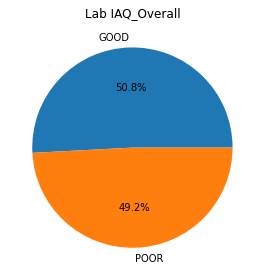

In [33]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(np.unique(data['IAQ'].values, return_counts=True)[1]/len(data), labels=np.unique(data['IAQ'].values, return_counts=True)[0], autopct='%.1f%%')
ax.set_title('Lab IAQ_Overall')
plt.tight_layout()

anticiper

In [34]:
n_seconds = 7
n_features = 14

reframed = series_to_supervised(scaled, n_seconds, 1)

In [35]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
7,0.003632,0.000143,0.504839,0.255490,0.075925,0.484318,0.0,0.532229,0.0,0.000000,...,0.000020,0.503226,0.221756,0.075922,0.498707,0.0,0.529062,0.0,0.067749,0.0
8,0.000000,0.000020,0.503226,0.245141,0.075925,0.487801,0.0,0.530976,0.0,0.063808,...,0.000000,0.501613,0.212793,0.075920,0.498278,0.0,0.528073,0.0,0.075717,0.0
9,0.000000,0.000000,0.503226,0.242316,0.075926,0.489156,0.0,0.530646,0.0,0.070936,...,0.000000,0.500000,0.207276,0.075919,0.497486,0.0,0.527347,0.0,0.118852,0.0
10,0.003632,0.004342,0.503226,0.236485,0.075925,0.491561,0.0,0.530514,0.0,0.094840,...,0.000000,0.498387,0.209201,0.075918,0.504289,0.0,0.526753,0.0,0.123460,0.0
11,0.000000,0.003099,0.504839,0.245246,0.075925,0.494003,0.0,0.530712,0.0,0.084740,...,0.000000,0.498387,0.196038,0.075917,0.505005,0.0,0.526094,0.0,0.114071,0.0
12,0.014542,0.002120,0.504839,0.242031,0.075925,0.497037,0.0,0.530382,0.0,0.020824,...,0.000000,0.498387,0.199882,0.075917,0.506226,0.0,0.525500,0.0,0.128370,0.0
13,0.014542,0.000245,0.506452,0.231752,0.075924,0.497285,0.0,0.529788,0.0,0.051555,...,0.000000,0.498387,0.207340,0.075915,0.510300,0.0,0.526687,0.0,0.167952,0.0
14,0.003632,0.000020,0.503226,0.221756,0.075922,0.498707,0.0,0.529062,0.0,0.067749,...,0.000000,0.498387,0.205613,0.075914,0.515023,0.0,0.527479,0.0,0.160974,0.0
15,0.010910,0.000000,0.501613,0.212793,0.075920,0.498278,0.0,0.528073,0.0,0.075717,...,0.000000,0.500000,0.199396,0.075917,0.520929,0.0,0.527743,0.0,0.136877,0.0
16,0.003632,0.000000,0.500000,0.207276,0.075919,0.497486,0.0,0.527347,0.0,0.118852,...,0.003629,0.498387,0.196817,0.075918,0.524297,0.0,0.527413,0.0,0.132634,0.0


In [36]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39992, 98) (39992, 11) (9991, 98) (9991, 11)


In [37]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(9991, 7, 14) (39992, 7, 14)


In [38]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units = 11))
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                3250      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                561       
Total params: 3,811
Trainable params: 3,811
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/500
1111/1111 - 2s - loss: 0.0817 - val_loss: 0.0498
Epoch 2/500
1111/1111 - 2s - loss: 0.0332 - val_loss: 0.0558
Epoch 3/500
1111/1111 - 2s - loss: 0.0284 - val_loss: 0.0508
Epoch 4/500
1111/1111 - 2s - loss: 0.0287 - val_loss: 0.0568
Epoch 5/500
1111/1111 - 2s - loss: 0.0282 - val_loss: 0.0548
Epoch 6/500
1111/1111 - 2s - loss: 0.0279 - val_loss: 0.0576
Epoch 7/500
1111/1111 - 2s - loss: 0.0275 - val_loss: 0.0490
Epoch 8/500
1111/1111 - 2s - loss: 0.0272 - val_loss: 0.0505
Epoch 9/500
1111/1111 - 2s - loss: 0.0270 - val_loss: 0.0443
Epoch 10/500
1111/1111 - 2s - loss: 0.0268 - val_loss: 0.0492
Epoch 11/500
1111/1111 - 2s - loss: 0.0264 - val_loss: 0.0500
Epoch 12/500
1111/1111 - 2s - loss: 0.0266 - val_loss: 0.0462
Epoch 13/500
1111/1111 - 2s - loss: 0.0261 - val_loss: 0.0453
Epoch 14/500
1111/1111 - 2s - loss: 0.0260 - val_loss: 0.0459
Epoch 15/500
1111/1111 - 2s - loss: 0.0256 - val_loss: 0.0445
Epoch 16/500
1111/1111 - 2s - loss: 0.0254 - val_loss: 0.0420
Epoch 17/500
1111

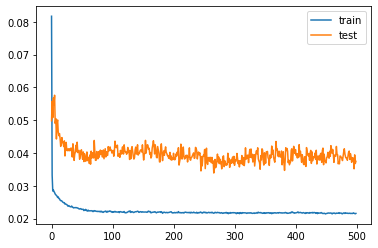

In [39]:
history = model.fit(train_X, train_y, epochs=500, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

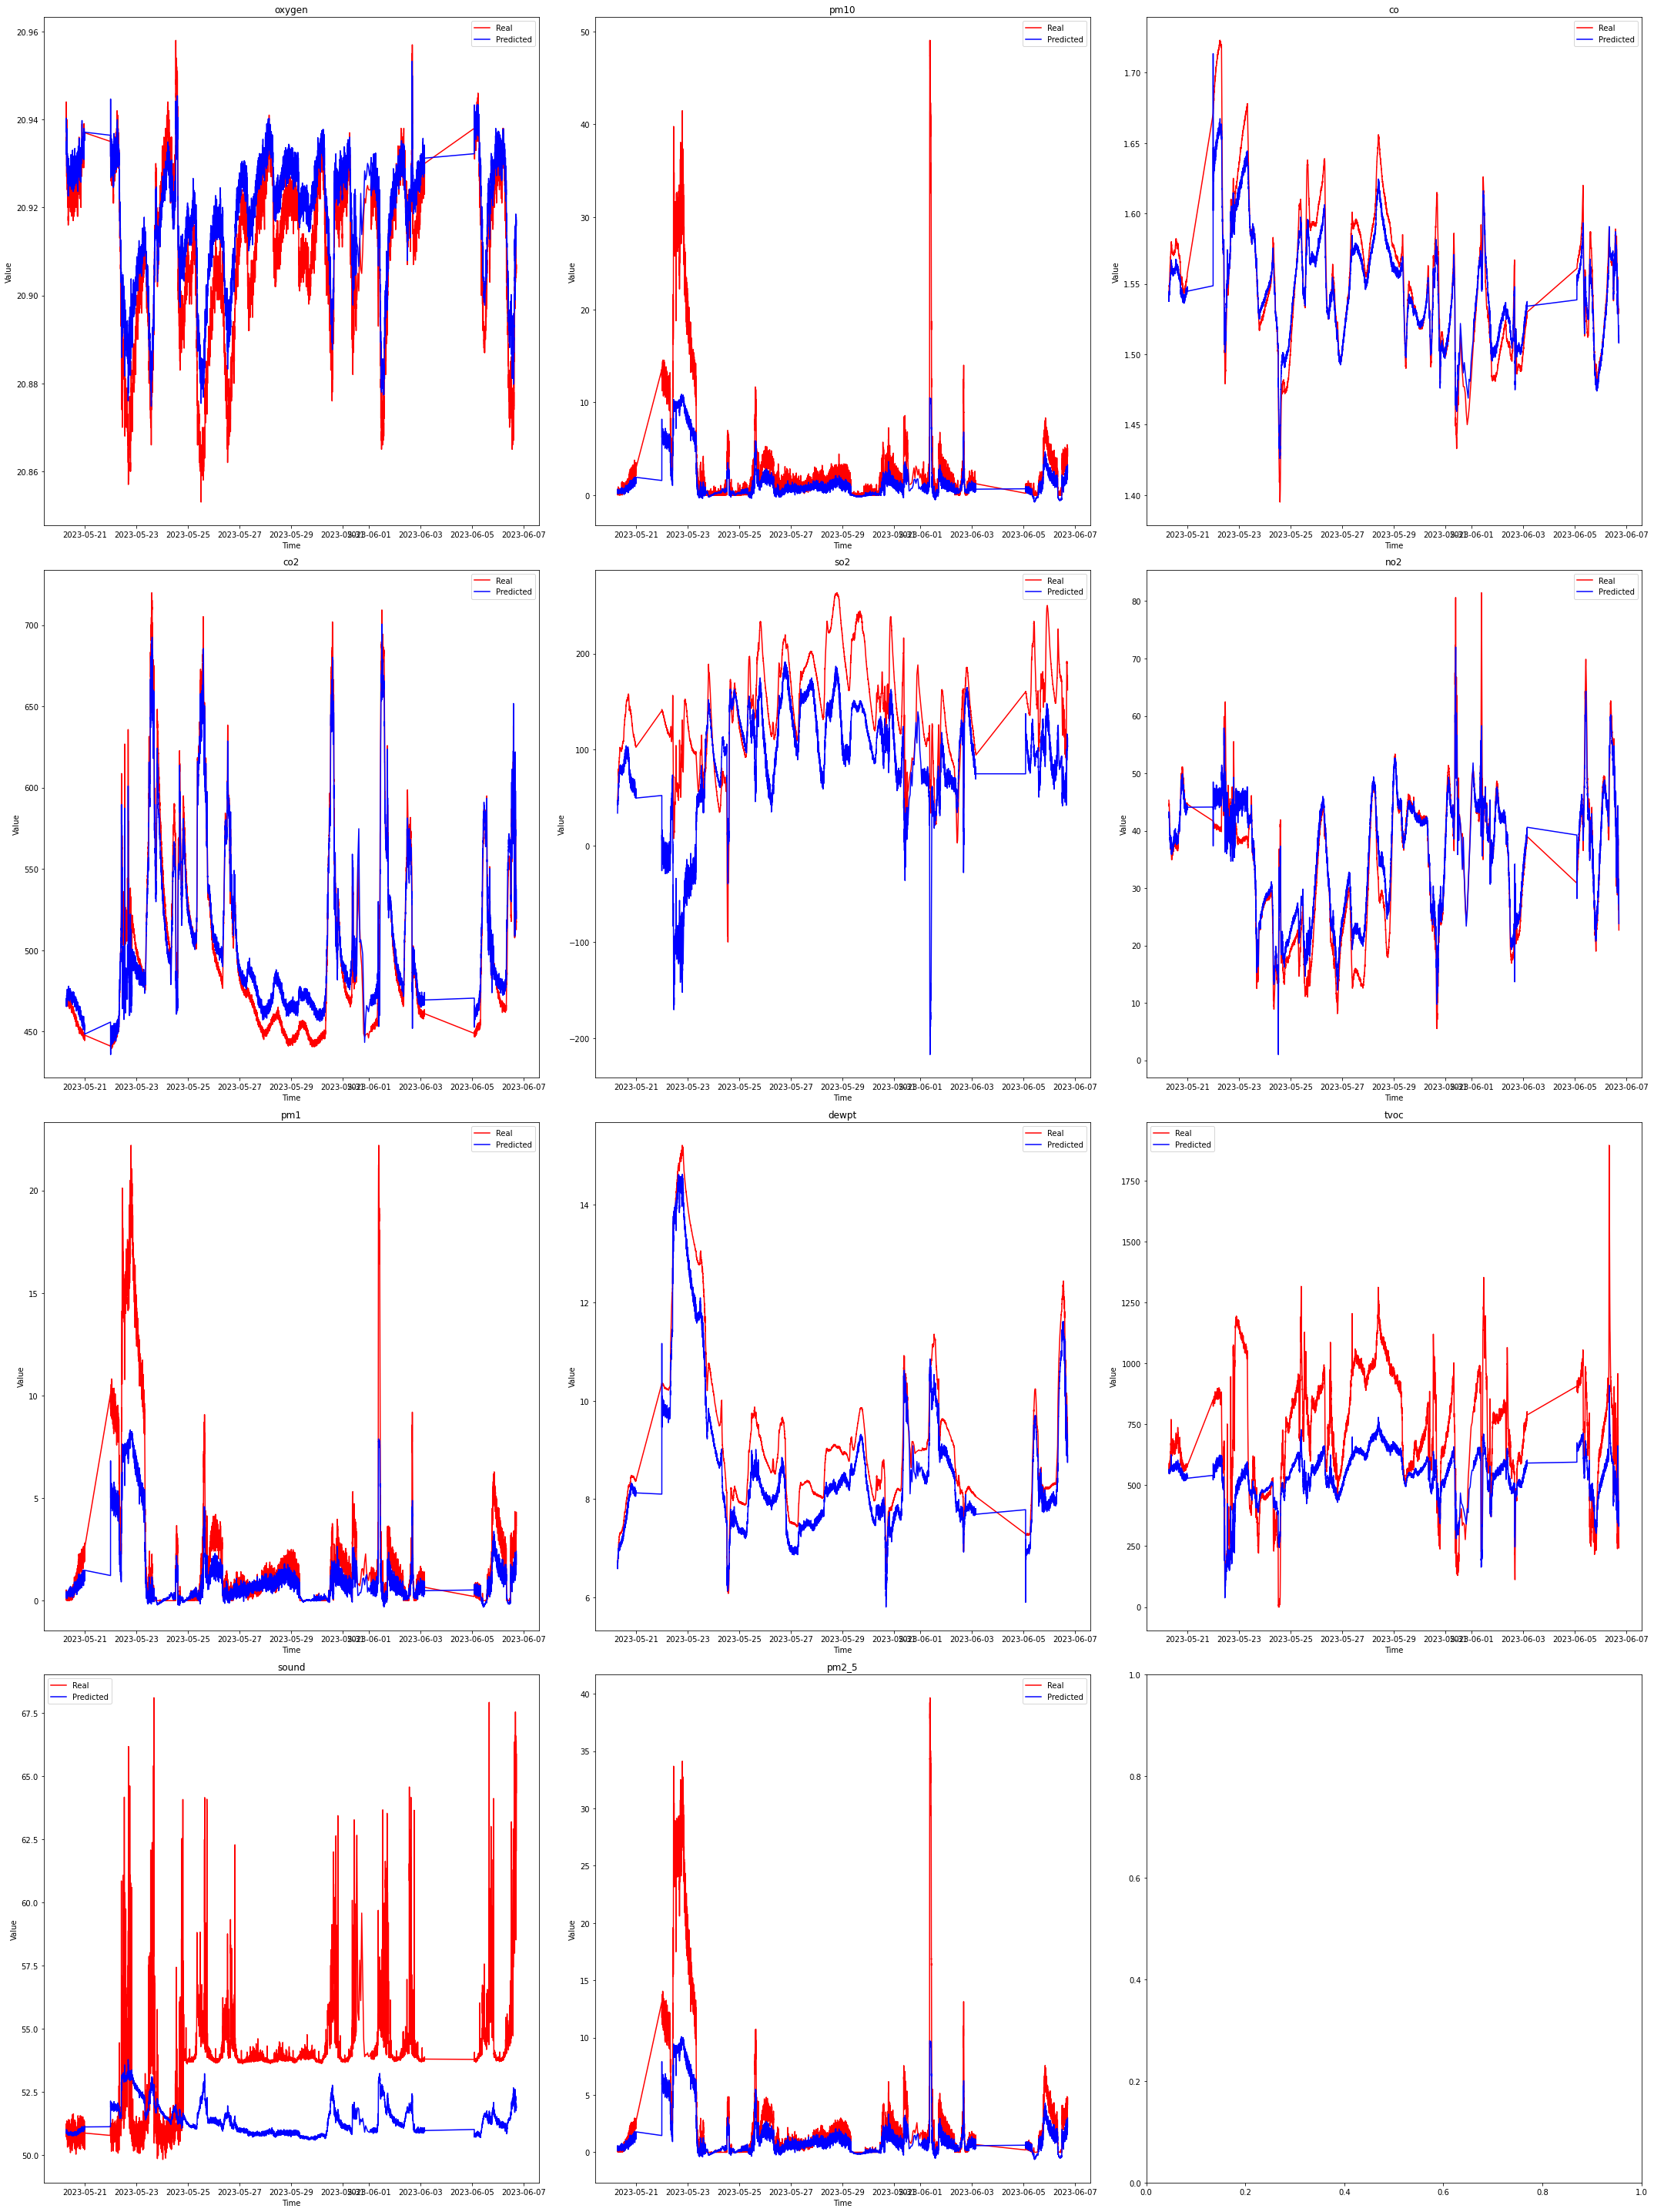

In [40]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [11, 12, 13]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape((len(test_y), 11))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns]
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'sound': 9, 'pm2_5': 10
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}
for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [41]:
selected_columns2 = [i for i in range(n_features) if i not in [11, 12, 13]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(9991, 11) (9991, 11)
Test RMSE for oxygen: 0.010
Test RMSE for pm10: 4.867
Test RMSE for co: 0.017
Test RMSE for co2: 14.882
Test RMSE for so2: 72.866
Test RMSE for no2: 3.651
Test RMSE for pm1: 2.426
Test RMSE for dewpt: 0.668
Test RMSE for tvoc: 251.735
Test RMSE for sound: 3.210
Test RMSE for pm2_5: 4.287
